In [1]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Pacman Dependancies

In [2]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

     |████████████████████████████████| 1.2 MB 6.8 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# Imports and Helper functions


In [1]:
import gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

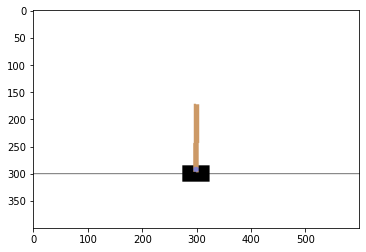

In [3]:
env = gym.make('CartPole-v1')
env.reset()

prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

In [4]:
# Set the seed for env, pytorch and random module
seed = 27
env.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [5]:
state_space = env.observation_space.shape[0]
action_space = env.action_space.n

In [6]:
def calculate_egreedy(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
                math.exp(-1. * steps_done / egreedy_decay)
    return epsilon

In [7]:
# define hyperparameters
num_episode = 500
gamma = 0.99
learning_rate = 0.001

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500
hidden_layer = 64
print_every = 10
egreedy_total = []

replay_memory_size = 50000
batch_size = 32
update_target_freq = 500
clip_error = False

In [8]:
class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition

        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))

    def __len__(self):
        return len(self.memory)

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(state_space, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, action_space)
    
    def forward(self, x):
        out = F.relu(self.linear1(x))
        out = self.linear2(out)
        return out

In [10]:
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params = self.nn.parameters(), lr = learning_rate)

        self.update_target_counter = 0

    def select_Action(self, state, epsilon):

        random_greedy = torch.rand(1)[0]

        if random_greedy > epsilon:
            with torch.no_grad():
                state = torch.Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn, 0)[1]
                action = action.item()
        else:
            action = env.action_space.sample()

        return action

    def optimize(self):

        if len(memory) < batch_size:
            return 

        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = torch.Tensor(state).to(device)
        new_state = torch.Tensor(new_state).to(device)
        reward = torch.Tensor(reward).to(device)
        action = torch.LongTensor(action).to(device)
        done = torch.Tensor(done).to(device)

        new_state_values = self.target_nn(new_state).detach()
        max_new_state_values = torch.max(new_state_values, 1)[0]
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()

        if clip_error:
            for param in self.nn.parameters():
                param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        if self.update_target_counter % update_target_freq == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())

        self.update_target_counter += 1
 

In [11]:
agent = QNet_Agent()
memory = ExperienceReplay(replay_memory_size)

In [12]:
steps_total = []
total_reward = []
frames_total = 0
score_to_solve = 195
solved_after = 0
solved = False
start_time = time.time()

for i_episode in range(num_episode):
    state = env.reset()
    step = 0
    #for step in range(100):
    while True:
        step += 1
        frames_total += 1
        epsilon = calculate_egreedy(frames_total)
        action = agent.select_Action(state, epsilon)
        new_state, reward, done, info = env.step(action)
        memory.push(state, action, new_state, reward, done)

        agent.optimize()

        state = new_state
        # screen = env.render(mode='rgb_array')
        # plt.imshow(screen)
        # ipythondisplay.clear_output(wait=True)
        # ipythondisplay.display(plt.gcf())
        if done:
            steps_total.append(step)
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % print_every == 0):
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % (i_episode,
                    print_every,
                    sum(steps_total[-print_every:])/print_every,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ))
                elapsed_time = time.time() - start_time
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

            break


*** Episode 0 ***                       
Av.reward: [last 10]: 1.50, [last 100]: 0.15, [all]: 15.00                       
epsilon: 0.87, frames_total: 15
Elapsed time:  00:00:00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)



*** Episode 10 ***                       
Av.reward: [last 10]: 17.60, [last 100]: 1.91, [all]: 17.36                       
epsilon: 0.62, frames_total: 191
Elapsed time:  00:00:00

*** Episode 20 ***                       
Av.reward: [last 10]: 23.80, [last 100]: 4.29, [all]: 20.43                       
epsilon: 0.39, frames_total: 429
Elapsed time:  00:00:01

*** Episode 30 ***                       
Av.reward: [last 10]: 16.60, [last 100]: 5.95, [all]: 19.19                       
epsilon: 0.29, frames_total: 595
Elapsed time:  00:00:01

*** Episode 40 ***                       
Av.reward: [last 10]: 12.10, [last 100]: 7.16, [all]: 17.46                       
epsilon: 0.23, frames_total: 716
Elapsed time:  00:00:02

*** Episode 50 ***                       
Av.reward: [last 10]: 9.80, [last 100]: 8.14, [all]: 15.96                       
epsilon: 0.19, frames_total: 814
Elapsed time:  00:00:02

*** Episode 60 ***                       
Av.reward: [last 10]: 10.30, [last 100]: 9.

In [13]:
print("Average reward: %.2f" % (sum(steps_total)/num_episode))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))

if solved:
    print("Solved after %i episodes" % solved_after)


Average reward: 155.70
Average reward (last 100 episodes): 240.95
Solved after 264 episodes


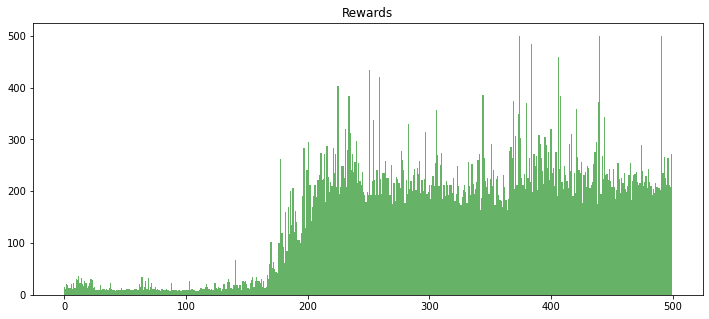

In [14]:
# Plot graphs for rewards and steps
    
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green', width=1)
plt.show()

In [15]:
env.close()